# Data Exploration

In [1]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing
import scipy.signal
from scipy import signal

import torch

We will be working with 693 recordings of dogs barking, recorded from 10 individuals across 3 different contexts. All audio has been recorded with a sample rate of 44.1 kHz.

The recordings vary in duration from 1 to 178 seconds. Since most deep learning models operate on data of fixed shape (for instance, 1 second of audio), this is something that we will need to address.

Let's begin by loading the data into a pandas dataframe along with the annotations. The dataset is small and it can fit into our RAM. This means that for every epoch of training, we will not have to load the data from disk.

In [2]:
SAMPLE_RATE = 44100

In [3]:
%%time

anno = pd.read_csv('data/annotations.csv')

audio = []

for _, row in anno.iterrows():
    recording, sr = librosa.load(f'data/audio/{row.filename}', sr=None)
    audio.append(recording)
    
anno['audio'] = audio

CPU times: user 8.17 s, sys: 796 ms, total: 8.96 s
Wall time: 8.96 s


We know that the duration of the recordings vary, but what is the distribution of their lengths?

In [4]:
recording_durations = anno.audio.apply(lambda x: x.shape[0] / SAMPLE_RATE)

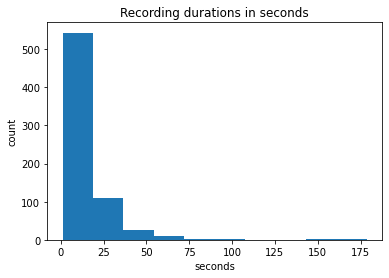

In [5]:
plt.title('Recording durations in seconds')
plt.xlabel('seconds')
plt.ylabel('count')
plt.hist(recording_durations);

In [6]:
min(recording_durations), max(recording_durations)

(1.0492290249433107, 178.6783446712018)

In [7]:
np.mean(recording_durations), np.median(recording_durations)

(12.770331595841808, 8.078775510204082)

Additionally, from the paper ["Barking in domestic dogs: context specificity and individual identification"](https://www.sciencedirect.com/science/article/abs/pii/S000334720400123X)) we learn that the duration of individual dog barks ranges from 38 to 137 miliseconds. This is a useful piece of information to take into account when considering how to format the data for feeding into our model.

In the paper, dog barks are manually segmented. Subsequently, multiple statistics are calculated on each bark. These values then serve as the basis for the classification.

The research question that is being answered is this - do dog barks carry information that can allow for the disambiguation of individuals and context?

The paper suggests that the answer is a yes. This is important. It is believed that for higher-level communication to occur, the signal needs to allow for the disambiguation of its origin, of the caller.

The question then becomes - can we arrive at similar results, using deep learning methods, ones that would not require manual segmentation of barks? Can we provide additional support for the hypothesis that indeed barks carry signal that allows for the disambiguation of the caller and in the process verify that our data processing methodology is sound?

Instead of working on raw audio, we will operate in the time-frequency domain. This adds further complexity - is the signal that allows for the disambiguation carried over into the time-frequency domain or does it get lost in transition?

Let's find out.

Below is a spectrogram calculated for one of the calls. This is what we plan to present to our model as the independent variable.

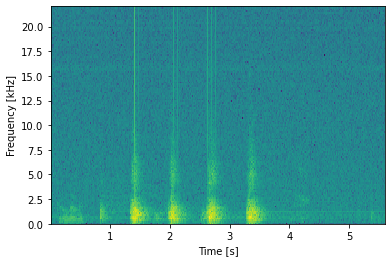

In [8]:
freqs, times, Sx = signal.spectrogram(anno.audio[10], fs=SAMPLE_RATE)
f, ax = plt.subplots()
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

Because of dog barks being low frequency, there is little to no value contained in the upper portion of the spectrogram. To limit the computation that we will need to perform, and to not feed what is going to be essentially noise into our model, we should be safe to include only frequencies up to the 10 kHz range.

Another problem that we need to address is how do we slice the data? Our deep learning model needs to operate on data of fixed shape.

Let's look at a couple more examples for inspiration.

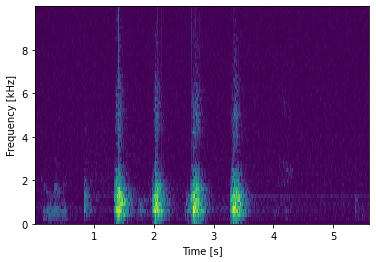

In [9]:
freqs, times, Sx = signal.spectrogram(anno.audio[10], fs=SAMPLE_RATE)
freqs, Sx = freqs[:59], Sx[:59] # dog barks are low frequency - we can safely limit the spectrogram
                                                   # to the 10 kHz range 
f, ax = plt.subplots()

epsilon = 1e-10
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx+epsilon), cmap='viridis') # adding a small value to avoid the divide
                                                                              # by zero issue  
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

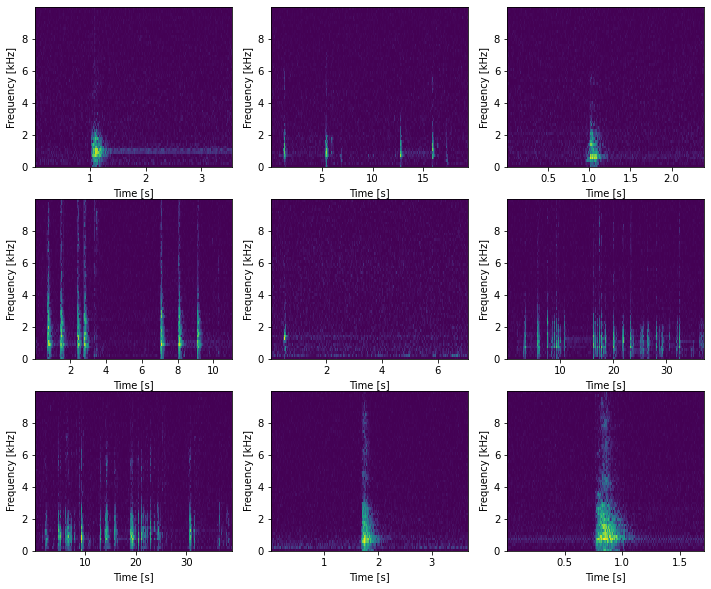

In [10]:
fig, subplots = plt.subplots(3, 3, figsize=(12,10))

for subplot in subplots.flat:
    freqs, times, Sx = signal.spectrogram(anno.audio[np.random.randint(anno.shape[0])], fs=SAMPLE_RATE)
    freqs, Sx = freqs[:59], Sx[:59] # dog barks are low frequency - we can safely limit the spectrogram
                                                       # to the 10 kHz range 
    epsilon = 1e-10
    subplot.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx+epsilon), cmap='viridis') # adding a small value to avoid the divide
                                                                                  # by zero issue  
    subplot.set_ylabel('Frequency [kHz]')
    subplot.set_xlabel('Time [s]');

Dog barks occur frequently in the recordings - meaning, there is rarely more than a second or two of silence in the recordings.

Deep learning methods are robust to random noise (here noise being defined as lack of signal, silence, having been assigned some label), thus we shouldn't probably worry too much about making the interval we will look at too small.

Purely arbitrarily, looking at the spectrograms, 2 seconds strike me as a good value.

Since we only have per recording labels, this is the level we will need to operate on. Meaning, we can feed our model 2 second chunks, but for the ultimate calculation of accuracy, we will need to output predictions for entire recordings.

This differs from the approach in the paper, where results are reported on bark level. We could go that route as well, but in order the report results in such a way, we would need to segment the barks either manually or automatically.

For a first pass through the data, let us focus on recording-level predictions.

Below we define a function that we will use to generate the spectrograms.

In [11]:
def audio_to_spec(audio):
    '''we'll use this function to go from audio to time-frequency representation'''
    _, _, Sx = signal.spectrogram(audio, fs=SAMPLE_RATE)
    epsilon = 1e-10
    return 10 * np.log10(Sx+epsilon)

We will be predicting dog identity. For reference, here are the per-bark results reported in the paper.

There is some information that our models will not have access too, such as for instance the inter-bark interval. This carries signal that can be very useful for disambiguating the context, it might also be helpful for identifying the caller. Let's see if our deep learning model can tackle this task regardless.

<img src='barks_results.png'>

## Training an individual classifier

For our model to be able to make predictions, we need to represent the names as indices.

In [12]:
idx2name = anno.name.unique().tolist()
name2idx = {name: idx for idx, name in enumerate(idx2name)}

And how are we planning to process individual examples? The idea, as discussed above, is to cut up recordings into 2 second sequences. Additionally, if a chunk of audio will be less than two seconds, we will zero pad it to appropriate length.

In [13]:
from functools import partial

def pad_to(num_seconds, audio):
    example = np.zeros(SAMPLE_RATE * num_seconds)
    example[:audio.shape[0]] = audio
    return example

pad_to_2seconds = partial(pad_to, 2)

In [14]:
pad_to_2seconds(anno.audio[526]).shape[0] / SAMPLE_RATE

2.0

We have a way of padding the examples to a length of two seconds, we now need a good way of splitting the recordings into train and validation sets.

In [15]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(shuffle=True)
folds = list(skfold.split(anno.name, anno.name))

The above method of splitting the dataset gives us stratified folds - we expect, proportionally, a similar number of recordings with barking from a given dog to make its way into the train and validation sets. We can confirm that this is the case.

In [16]:
anno.iloc[folds[0][0]].name.value_counts() / folds[0][0].shape[0]

Roodie    0.218412
Luke      0.169675
Mac       0.122744
Zoe       0.108303
Siggy     0.102888
Farley    0.075812
Freid     0.064982
Keri      0.059567
Louie     0.046931
Rudy      0.030686
Name: name, dtype: float64

In [17]:
anno.iloc[folds[0][1]].name.value_counts() / folds[0][1].shape[0]

Roodie    0.223022
Luke      0.165468
Mac       0.129496
Siggy     0.100719
Zoe       0.100719
Farley    0.071942
Freid     0.064748
Keri      0.064748
Louie     0.050360
Rudy      0.028777
Name: name, dtype: float64

Time to construct the datasets and dataloaders now. We will cut up the incoming recordings into audio chunks of 2 seconds of length.

In [18]:
EXAMPLE_LENGTH = 2 # given in seconds

def cut_into_examples_and_reconstruct_dataframe(df):
    names, audio, idxs = [], [], []

    for idx, vals in df.iterrows(): # we iterate over all the rows in our dataset
        while True: # we then iterate over audio, cutting it up into two second examples
            example = pad_to_2seconds(vals['audio'][:EXAMPLE_LENGTH*SAMPLE_RATE])
            audio.append(example)
            names.append(vals['name'])
            idxs.append(idx)
            if vals['audio'].shape[0] >= EXAMPLE_LENGTH*SAMPLE_RATE:
                vals['audio'] = vals['audio'][EXAMPLE_LENGTH*SAMPLE_RATE:] 
            else: break
    return pd.DataFrame(data={'name': names, 'audio': audio, 'original_index': idxs})

class Dataset():
    def __init__(self, df):
        self.examples = cut_into_examples_and_reconstruct_dataframe(df)
    def __getitem__(self, idx):
        x = audio_to_spec(self.examples.audio[idx])
        x = np.tile(x[:, :, None], 3).transpose(2,0,1) # we will use a cnn architecture which expects
                                                                     # a 3-channel input
        y = name2idx[self.examples.name[idx]]
        return x.astype(np.float32), y
    def __len__(self):
        return self.examples.shape[0]

In [19]:
train_set = Dataset(anno.iloc[folds[0][0]])
valid_set = Dataset(anno.iloc[folds[0][1]])

In [20]:
len(train_set), len(valid_set)

(3923, 858)

We have the datasets - let's construct the dataloaders! Dataloaders will iterate over our datasets and pass them to our model during training.

We will use `PyTorch` and only rely on `fastai` for providing the training loop.

In [21]:
import torch

In [48]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)

In [78]:
from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.vision.all import *
from fastai.callback.data import CudaCallback
from fastai.metrics import *

dls = DataLoaders(train_dl, valid_dl)
learn = cnn_learner(
    dls,
    resnet18, # we are using the time-tested, small, quick to train, resnet18 architecture
    n_out=10, # the fastai library modifies the architecture behind the scenes for us to use with our data
    pretrained=False,
    loss_func=torch.nn.CrossEntropyLoss(),
    cbs=[CudaCallback],
    metrics=[accuracy]
)

We use the learning rate finder to find a good hyperparameter (the learning rate) to train our model.

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=9.12010818865383e-07)

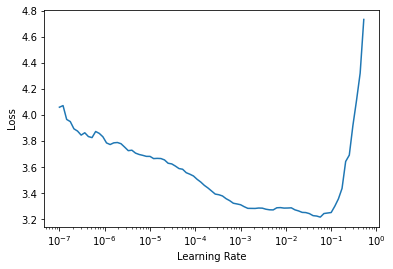

In [66]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.804824,10.537081,0.149184,00:24
1,2.399063,25.394440,0.145688,00:24
2,1.948053,23.533815,0.032634,00:24
3,1.592163,9.429598,0.193473,00:24
4,1.346867,12.120504,0.264569,00:24
5,1.199466,7.659751,0.193473,00:24
6,1.071647,4.618165,0.321678,00:24
7,0.966581,4.343807,0.383450,00:24
8,0.880121,1.086338,0.645688,00:24


The accuracy obtained during training is calculated on a chunk per chunk basis. But we assume there are some chunks that will not contain barks, etc. Let us go back to our original plan of calculating the accuracy on a per recording basis, for each recording in the validation set.

In [70]:
preds, targs = learn.get_preds(dl=valid_dl)

In [71]:
results = []
for grp in valid_set.examples.groupby('original_index'): # I am iterating through the results
                                                         # grouping predictions on recording level
    target = name2idx[grp[1].name.iloc[0]]
    prediction = int(preds[grp[1].index].mean(0).argmax()) # I am aggregating the predictions from multiple chunks
                                                           # via taking their mean
    results.append(target == prediction)

In [72]:
np.mean(results)

0.9424460431654677

On a recording level prediction, with minimal amount of training, we achieve an accuracy of nearly 94%. Across 10 classes, with the accuracy of a random guess equaling 10%, with the dataset being imbalanced, that is a good result.

Our findings do support the hypothesis presented in the paper, that is that identity can be inferred from barks.

It is important to note that we carried out the analysis above without having to manually process each recording to pinpoint the barks. However, this comes at the cost of not being able to speak to the frequencies of the calls, to capturing the insight across which descriptors they differ, etc.

Further work on this dataset could include pushing our results further, to achieve better accuracy. It would also be interesting to segment out the barks in an automated way and see what results can be obtained when training on individual vocalizations, in particular of dogs of the same breed.